# Um Chatbot para conversa sobre Alzheimer

### Importar bibliotecas e configurar ambiente

In [1]:
import os
import time
import dotenv
from IPython.display import Image

import operator
from typing import Annotated, TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
# Set up env variables
print("Is env variables loaded?", dotenv.load_dotenv(".env"))

Is env variables loaded? True


### Criar Agente

#### 1. Definir o Estado do Grafo

A seguir definimos o estado do grafo. Há diversas formas de fazer isso. Aqui, criaremos uma classe do tipo `TypedDict` que possui um atributo `messages`. 

No fluxo padrão de um grafo do LangGraph, os atributos do estado são sobrescritos. Porém, em nosso chatbot, queremos guardar todas as mensagens. Por isso, anotamos o atributo *messages* com o **reducer** `operator.add`, o qual faz o append de novas mensagens, ao invés de sobrescrever.

Ao invés de definirmos o estado manualmente, neste caso, poderíamos utilizar como alternativa a classe `MessagesState`, que também define um estado com um atributo *messages* que é expandido ao longo da interação: `from langgraph.graph import MessagesState`.

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#### 2. Criar Grafo

A seguir, seguimos nossa receita de construção de um agente com LangGraph, definindo e criando nós, arestas e o grafo do fluxo de controle. Colocamos todos esses passos dentro de uma classe `ChatbotAlzheimer`. Porém, poderíamos ter adotado outras abordagens.

Em cada etapa da construção do grafo, poderíamos ter adotado diferentes estratégias. As apresentadas a seguir são apenas uma das formas de fazermos as coisas. Algumas observações adicionais são:

1. Na definição do nó de tools (`tools_node`), ao invés de termos criado manualmente, poderíamos ter utilizado a classe `ToolNode`, que é uma classe built-in do LangGraph que sabe executar as tools chamadas na última AIMessage. Sua lógica é semelhante à implementação que realizamos.
    - `from langgraph.prebuilt import ToolNode`
2. Na definição da aresta conditional (`tools_conditional_edge`) também poderíamos ter utilizado uma função built-in do LangGraph, chamada `tools_condition`, que encaminha o fluxo para o nó de tools (neste caso ele precisa se chamar `tools`) ou para o nó END, a depender da última mensagem da IA.

In [4]:
class ChatbotAlzheimer:

    def __init__(self, model_name, tools, checkpointer, playground_with_tools = False, playground_with_memory = False):
        self.chat_model = ChatOpenAI(model=model_name, temperature=0)
        self.tools_dict = {t.name: t for t in tools}
        
        if playground_with_tools:
            self.chat_model = self.chat_model.bind_tools(tools=tools)
        
        if playground_with_memory:
            self.agent_graph = self.create_graph(checkpointer=checkpointer)
        else:
            self.agent_graph = self.create_graph(checkpointer=None)
    
    # 2. Define the nodes
    def chat_node(self, state: AgentState):
        system_prompt = ("Você é um chatbot especializado em responder perguntas sobre Alzheimer."
                        " Caso não saiba responder à pergunta, não invente uma resposta, mas utilize alguma das tools ({0}) para buscar informações relevantes."
                        " Se tiver buscado por informações relevantes, utilize os conteúdos retornados para te ajudar a responder")
        
        system_prompt = system_prompt.format(",".join(self.tools_dict.keys()))
        system_message = SystemMessage(content=system_prompt)
        model_input = [system_message] + state["messages"]
        
        response = self.chat_model.invoke(input = model_input)

        return {"messages": [response]}
    
    def tools_node(self, state: AgentState):
        result = []

        for tool_call in state["messages"][-1].tool_calls:
            tool = self.tools_dict[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append(ToolMessage(content=str(observation), tool_call_id = tool_call["id"], name=tool_call["name"]))
        
        return {"messages": result}
    
    # 3. Define conditional edges
    def tools_conditional_edge(self, state: AgentState):
        last_message = state["messages"][-1]

        if last_message.tool_calls:
            return "tools_node"
        else:
            return END
    
    # 4. Put all things together
    def create_graph(self, checkpointer):
        # 4.1. Instantiate a graph control workflow from the defined State
        graph_workflow = StateGraph(AgentState)
        # 4.2. Create the nodes
        graph_workflow.add_node("chat_node", self.chat_node)
        graph_workflow.add_node("tools_node", self.tools_node)
        # 4.3. Create the edges
        graph_workflow.add_edge(START, "chat_node")
        graph_workflow.add_conditional_edges(
            source="chat_node",
            path=self.tools_conditional_edge
        )
        graph_workflow.add_edge("tools_node", "chat_node")
        # 4.4. Compile the graph
        graph_workflow = graph_workflow.compile(checkpointer=checkpointer)

        return graph_workflow

### Brincando com o chat

#### Definindo elementos básicos

In [5]:
def print_messages(messages):
    for msg in messages:
        msg.pretty_print()

In [6]:
def chatbot_loop(chatbot, config=None):
    user_input = ""

    while True:
        user_input = input("Typing: ")

        if user_input == "END":
            break
        
        user_input = [HumanMessage(content=user_input, name="User")]
        
        if not config:
            response = chatbot.invoke(input={"messages": user_input})
        else:
            response = chatbot.invoke(input={"messages": user_input}, config=config)

        time.sleep(3)

        print_messages(response["messages"])
        print("***"*35)


Como tool, vamos o [Tavily](https://tavily.com/), que é um motor de busca/API otimizada para LLMs e RAG. Uma de suas principais diferenças em relação às técnicas usuais de buscas na web é que ela abstrai toda a complexidade de:
1. Procurar links com informações relevantes para nossa pergunta.
2. Extrair as informações desses links.
3. Selecionar informações mais relevantes.
4. Apresentar o conteúdo.

Assim, ele nos retorna o conteúdo no formato ideal para ser utilizado pela LLM, assim como alguns metadados.

Outro ponto a se destacar aqui é que, neste exemplo, utilizamos o `MemorySaver`como nosso checkpointer. Ele nos permite salvar os estados do nosso grafo em memória. Porém, tanto o LangChain como o LangGraph fornecem outras alternativas para persistirmos nosso grafo, inclusive de maneira mais duradoura, como banco SQLite, MongoDB, etc.

In [7]:
model_name = "gpt-3.5-turbo"
tavily_tool = TavilySearchResults(max_results=4)
checkpointer = MemorySaver()

#### Playground 1: Chatbot sem tools e sem memória

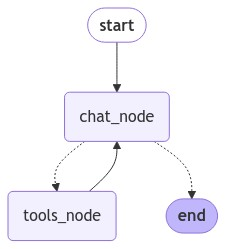

In [10]:
chatbot_no_tool_no_mem = ChatbotAlzheimer(model_name=model_name, tools=[tavily_tool], checkpointer=checkpointer,
                                          playground_with_tools=False, playground_with_memory=False)

display(Image(chatbot_no_tool_no_mem.agent_graph.get_graph().draw_mermaid_png()))

In [11]:
chatbot_loop(chatbot=chatbot_no_tool_no_mem.agent_graph, config=None)

Typing:  Oi, meu nome é Marianna. Tudo bem?


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Tudo bem sim, obrigado por perguntar. Como posso te ajudar hoje?
*********************************************************************************************************


Typing:  O que é o Alzheimer?


================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================

O Alzheimer é uma doença neurodegenerativa progressiva que afeta o cérebro, causando problemas de memória, pensamento e comportamento. É a forma mais comum de demência em idosos e geralmente se desenvolve lentamente ao longo do tempo. A doença de Alzheimer afeta a capacidade da pessoa de realizar tarefas cotidianas e pode ter um impacto significativo na qualidade de vida do paciente e de seus familiares.
*********************************************************************************************************


Typing:  Qual é o meu nome?


================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Desculpe, mas como sou um assistente virtual, não tenho acesso a informações pessoais sobre você, como seu nome. Posso te ajudar com informações sobre o Alzheimer, se precisar. Como posso ajudar você hoje?
*********************************************************************************************************


Typing:  Sobre o que te perguntei anteriormente?


================================ Human Message =================================
Name: User

Sobre o que te perguntei anteriormente?
================================== Ai Message ==================================

Você me perguntou sobre o Alzheimer. Como posso te ajudar hoje?
*********************************************************************************************************


Typing:  END


#### Playground 2: Chatbot com tools e sem memória

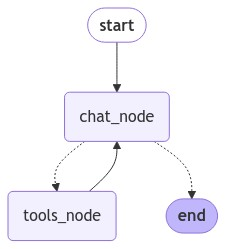

In [12]:
chatbot_no_mem = ChatbotAlzheimer(model_name=model_name, tools=[tavily_tool], checkpointer=checkpointer,
                                          playground_with_tools=True, playground_with_memory=False)

display(Image(chatbot_no_mem.agent_graph.get_graph().draw_mermaid_png()))

In [13]:
chatbot_loop(chatbot=chatbot_no_mem.agent_graph, config=None)

Typing:  Oi meu nome Marianna. Tudo bem?


================================ Human Message =================================
Name: User

Oi meu nome Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
*********************************************************************************************************


Typing:  O que é o Alzheimer?


================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_eb7LZump6JttFoBd8YE3w3Ww)
 Call ID: call_eb7LZump6JttFoBd8YE3w3Ww
  Args:
    query: O que é o Alzheimer?
================================= Tool Message =================================
Name: tavily_search_results_json

[{'url': 'https://www.mdsaude.com/neurologia/mal-alzheimer/', 'content': 'Doença de Alzheimer: O que é, sintomas e tratamento O mal de Alzheimer, também conhecido como doença de Alzheimer, é uma doença degenerativa e progressiva que provoca atrofia do cérebro, levando à demência em pacientes idosos. O mal de Alzheimer é uma doença de lenta e progressiva evolução, que destrói as funções mentais importantes, levando o paciente à demência, um termo usado para indicar que o indivíduo perdeu suas capacidades de raciocínio, julgamento e 

Typing:  Quais são os principais sintomas?


================================ Human Message =================================
Name: User

Quais são os principais sintomas?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_6mTWDXKNNMjRxvu5u7WjX8Vw)
 Call ID: call_6mTWDXKNNMjRxvu5u7WjX8Vw
  Args:
    query: principais sintomas do Alzheimer
================================= Tool Message =================================
Name: tavily_search_results_json

[{'url': 'https://alzheimerportugal.org/10-sinais-de-alerta/', 'content': 'Muitos dos sintomas da Doença de Alzheimer podem ser, também, sintomas de outras doenças como, por exemplo, depressão. Por isso, caso detete alguns destes sinais, consulte o seu médico de família. Esta lista pode ajudá-lo a reconhecer os sinais de alerta da Doença de Alzheimer: 1. Perda de Memória'}, {'url': 'https://www.uol.com.br/vivabem/noticias/redacao/2024/01/24/alzheimer-como-a-doenca-prejudica-o-cerebro-e-quais-os-principais-s

Typing:  Qual é o meu nome?


================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Desculpe, mas não tenho essa informação. Como posso te ajudar com informações sobre Alzheimer hoje?
*********************************************************************************************************


Typing:  Sobre o que eu te perguntei anteriormente?


================================ Human Message =================================
Name: User

Sobre o que eu te perguntei anteriormente?
================================== Ai Message ==================================

Você me pediu para responder perguntas sobre o Alzheimer. Como posso te ajudar hoje?
*********************************************************************************************************


Typing:  END


#### Playground 3: Chatbot com tools e com memória

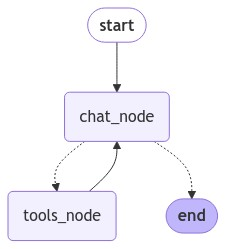

In [14]:
chatbot_complete = ChatbotAlzheimer(model_name=model_name, tools=[tavily_tool], checkpointer=checkpointer,
                                          playground_with_tools=True, playground_with_memory=True)

display(Image(chatbot_complete.agent_graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "1"}}
chatbot_loop(chatbot=chatbot_complete.agent_graph, config=config)

Typing:  Oi, meu nome é Marianna. Tudo bem?


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
*********************************************************************************************************


Typing:  Qual é o meu nome?


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Seu nome é Marianna. Como posso te ajudar hoje, Marianna?
*********************************************************************************************************


Typing:  O que é o Alzheimer?


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Seu nome é Marianna. Como posso te ajudar hoje, Marianna?
================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_AqMdAeB28OQFonE7nqiZJsMz)
 Call ID: call_AqMdAeB28OQFonE7nqiZJsMz
  Args:
    query: O que é o Alzheimer?
================================= Tool Message =================================
Name: tavily_search_results_json

[{'url'

Typing:  Com quantos anos os sintomas começam a se manifestar?


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Seu nome é Marianna. Como posso te ajudar hoje, Marianna?
================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_AqMdAeB28OQFonE7nqiZJsMz)
 Call ID: call_AqMdAeB28OQFonE7nqiZJsMz
  Args:
    query: O que é o Alzheimer?
================================= Tool Message =================================
Name: tavily_search_results_json

[{'url'

Typing:  Sobre o que te perguntei anteriormente?


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Seu nome é Marianna. Como posso te ajudar hoje, Marianna?
================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_AqMdAeB28OQFonE7nqiZJsMz)
 Call ID: call_AqMdAeB28OQFonE7nqiZJsMz
  Args:
    query: O que é o Alzheimer?
================================= Tool Message =================================
Name: tavily_search_results_json

[{'url'

Typing:  Me dê mais detalhes sobre as minhas dúvidas


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Seu nome é Marianna. Como posso te ajudar hoje, Marianna?
================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_AqMdAeB28OQFonE7nqiZJsMz)
 Call ID: call_AqMdAeB28OQFonE7nqiZJsMz
  Args:
    query: O que é o Alzheimer?
================================= Tool Message =================================
Name: tavily_search_results_json

[{'url'

Typing:  Qual é o meu nome?


================================ Human Message =================================
Name: User

Oi, meu nome é Marianna. Tudo bem?
================================== Ai Message ==================================

Olá, Marianna! Estou aqui para ajudar. Como posso te auxiliar hoje?
================================ Human Message =================================
Name: User

Qual é o meu nome?
================================== Ai Message ==================================

Seu nome é Marianna. Como posso te ajudar hoje, Marianna?
================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_AqMdAeB28OQFonE7nqiZJsMz)
 Call ID: call_AqMdAeB28OQFonE7nqiZJsMz
  Args:
    query: O que é o Alzheimer?
================================= Tool Message =================================
Name: tavily_search_results_json

[{'url'

Typing:  END


In [21]:
config = {"configurable": {"thread_id": "2"}}
chatbot_loop(chatbot=chatbot_complete.agent_graph, config=config)

================================ Human Message =================================
Name: User

Oi, meu nome é Leticia
================================== Ai Message ==================================

Olá, Leticia! Como posso te ajudar hoje?
*********************************************************************************************************
================================ Human Message =================================
Name: User

Oi, meu nome é Leticia
================================== Ai Message ==================================

Olá, Leticia! Como posso te ajudar hoje?
================================ Human Message =================================
Name: User

Qual é a porcentagem da população no brasil hoje que possui alzheimer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_CcbiCJXKdxbKXiTfo48FXlSY)
 Call ID: call_CcbiCJXKdxbKXiTfo48FXlSY
  Args:
    query: porcentagem da população no Brasil com 

In [22]:
config = {"configurable": {"thread_id": "1"}}
chatbot_loop(chatbot=chatbot_complete.agent_graph, config=config)

================================ Human Message =================================
Name: User

Oi, meu nome é Marianna
================================== Ai Message ==================================

Olá, Marianna! Como posso te ajudar hoje?
================================ Human Message =================================
Name: User


================================== Ai Message ==================================

Como posso te ajudar hoje?
================================ Human Message =================================
Name: User

Como é o meu nome?
================================== Ai Message ==================================

Seu nome é Marianna. Como posso ajudar você, Marianna?
================================ Human Message =================================
Name: User

O que é o Alzheimer?
================================== Ai Message ==================================

O Alzheimer é uma doença neurodegenerativa progressiva que afeta o cérebro, causando problemas de memória, pens